# Case Study 1 - Predicting Superconductors 

__Team Members:__ Amber Clark, Andrew Leppla, Jorge Olmos, Paritosh Rai

# Content
* [Business Understanding](#business-understanding)
* [Data Evaluation](#data-evaluation)
    - [Data Understanding](#data-understanding)
    - [Missing Values](#missing-values)
    - [Which Values are needed](#values-needed)
    - [Assumptions](#assumptions)
* [Model Preparations](#model-preparations)
    - [Method](#method)
    - [Evaluation Metrics](#evaluation-metrics)
* [Model Building & Evaluations](#model-building)
    - [Sampling Methodology](#sampling-methodology)
    - [L1 Model](#L1-model)
    - [L2 Model](#L2-model)
    - [Analysis](#analysis)
* [Model Interpretability & Explainability](#model-explanation)
* [Conclusion](#conclusion)

# Business Understanding & Executive Summary <a id='business-understanding'/>

### Scope
The objective of the case study is to identify what elements and material characteristics predict superconductor critical temperatures. This is done by regressing the critical temperature of many superconductors with varying elemental composition and quantitative material characteristics.

### Introduction
A superconductor is a material that will exhibit extremely low to no electrical resistance at a sufficiently low enough temperature, resulting in infinite conductivity. This still little-understood phenomenon at which a material reaches the physical state of superconductivity occurs suddenly at a temperature known as the critical temperature. In 1911 the Dutch physicist Heike Kamerlingh Onnes discovered Mercury (Hg) as the first superconductor at a critical temperature of 4 degrees Kelvin (or -424 degrees Fahrenheit). Since then, researchers have discovered and developed many superconducting compounds, including metal alloys and ceramics, intending to find materials with higher critical temperatures (or ideally, those as close to room temperature as possible), as the requirement of extreme cooling is both expensive and challenging to achieve.
The dataset contains 21,263 observations of materials. The information for these observations includes the ratios of 77 different elements and 81 quantitative material characteristics of the compounds. The goal is to predict the Critical Temperature and find which combination of these variables can positively or negatively correlate most with increased critical temperature to identify valuable new superconductors' traits.

### Methods
Dataset provided two files containing measurements of material characteristics and another with the elemental compositions. The two files were combined for use in this analysis along with the target response variable, critical temperature. There were no missing values in the data provided for this analysis. The team also identified a few outliers' (82 rows) in the clean-up process. The team worked on a model that will help determine which individual features contribute most to increases in critical temperature. Therefore, linear regression is best for this case as the response variable is continuous. The team split the data as a training set to build the model and a test set to validate the model's outcome. 
After combining the two data files, the data set contained 158 features to start. This dataset was very complex to interpret and drive any kind of correlation and may result in over-fitting the model. After initial exploration of the dataset, the team built a linear model with all 158 features as a baseline. Followed by the linear model using a LASSO algorithm to select the most pertinent variables, and then Ridge regression to fit the model using the smaller set of variables chosen to reduce the chances of overfitting without further reducing the number of variables . The primary objective was to reduce the number of explanatory variables, to build a meaningful model and ensure the accuracy and explain ability of a dependable variable by the independent variable is not compromised.
 The prime criteria to evaluate the model was to minimize the error (mean square error) and increase the explanation of the relationship between independent and dependent variables (R<sup>2</sup>). The team also made a few manual adjustments to optimize (trade-off) the model's accuracy and enhance the model interpretation. The team investigated the correlations, checked the multi-collinearity, and kept the most relevant features. 
 
### Results
Todo: The coefficients representing the feature importance in the final linear model and the summary table with vital statistics are shown in the figures below.

<img src="summary_table.png" width=250 height=250 />

The team started building the model with the notion of predicting the critical temperature based on given element composition and material characteristics. Thermal Conductivity, Atomic Mass, and Atomic Radius had the highest __positive__ influence on critical temperature of superconductors to achieve superconductivity. Also, the presence of Barium (Ba), Calcium (Ca) and Bismuth (Bi) helps increase the critical temperature.  Variables related to Valence, Density, Electron Affinity, and Fusion Heat had the highest __negative__ influence on critical temperatures. Additionally the presence of Silicon (Si), Arsenic (As), Praseodymium (Pr) decrease the critical temperature.

We observed an interesting result that only nine (9) material characteristics and thirteen (13) elements, out of 158 total, were needed to predict critical temperature. This model could potentially provide the scientific community with some insight to narrow their research to a few key factors and elements.

# Data Evaluation <a id='data-evaluation'>
    

The data comes from a Japanese database, Materials Data Repository.  It is a database repository or materials research and publications.  The data we are working with has been used in a variety of analysis and publications available online conducting similar analysis to what we have done in our assignment.

In [1]:
# standard libraries
import pandas as pd
import numpy as np
from IPython.display import Image

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from tabulate import tabulate

# data pre-processing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# prediction models
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from kneed import KneeLocator
from scipy import stats

# import warnings filter
import warnings
warnings.filterwarnings('ignore')
from warnings import simplefilter 
simplefilter(action='ignore', category=FutureWarning)

## Loading Data

After loading data we noticed that all but three of the characteristics (number of elements, range of atomic mass of radius, range of valence) are floats.

In [2]:
materials = pd.read_csv('superconduct/unique_m.csv') 
characteristics = pd.read_csv('superconduct/train.csv')

## Summarize Data

In [3]:
datadictionary = pd.read_csv('datadictionary.csv') 
col_names = ["Variable", "Description", "Type"]
print(tabulate(datadictionary, headers=col_names, tablefmt='fancy_grid'))

╒════╤═════════════════════════════════╤══════════════════════════════════════════════════════╤═════════╕
│    │ Variable                        │ Description                                          │ Type    │
╞════╪═════════════════════════════════╪══════════════════════════════════════════════════════╪═════════╡
│  0 │ number_of_elements              │ number of elements                                   │ Integer │
├────┼─────────────────────────────────┼──────────────────────────────────────────────────────┼─────────┤
│  1 │ mean_atomic_mass                │ mean of atomic mass                                  │ Float   │
├────┼─────────────────────────────────┼──────────────────────────────────────────────────────┼─────────┤
│  2 │ wtd_mean_atomic_mass            │ weighted mean of atomic mass                         │ Float   │
├────┼─────────────────────────────────┼──────────────────────────────────────────────────────┼─────────┤
│  3 │ gmean_atomic_mass               │ geome

## Missing Values

We looked at both the materials datasets and the train dataset and there appears to be no any missing values.

In [4]:
materials.isnull().values.any()

False

In [5]:
characteristics.isnull().values.any()

False

## Feature Removal

We removed 9 elements (He', 'Ne', 'Ar', 'Kr', 'Xe', 'Pm', 'Po', 'At', 'Rn') that were not present in any of the materials we examined, therefore they will not contribute to the model. We speculate that the reason for these elements not showing up in any of the materials is that they're noble gases and don't have the propensity to react with any other elements. We additionally removed three characterics ('wtd_gmean_ThermalConductivity', 'wtd_std_ThermalConductivity','range_fie') from our features that were indentified from the multicollinearity analysis and instead kept the features that had higher correlations with the critical temperature.

In [6]:
describe =  materials.describe()
cols = describe.columns
material_drops = [c for c in cols if describe[c]['max'] == 0.0]
print("Material Drops", material_drops)

Material Drops ['He', 'Ne', 'Ar', 'Kr', 'Xe', 'Pm', 'Po', 'At', 'Rn']


In [7]:
materials = materials.drop(material_drops, axis = 1)

#### Clean up files before combining, critical temp (duplicated in characteristics) and material (unneeded) from materials

In [8]:
materials = materials.drop(['critical_temp', 'material'], axis = 1)

#### Combining Datasets

In [9]:
df = pd.concat([materials, characteristics ], axis=1)

## Exploratory Data Analysis (EDA)

### Examining Distribution of Target Variable: Critical Temperature

Even though it is skewed, our sample size is large enough for the Central Limit Theorem to apply.  We noticed the data is bimodal, which could indicate that there are different relationships for high temperature superconductors and regular superconductors (does not represent 1 population), making data interpretation more dificult.

#### Distribution of Critical Temperature 

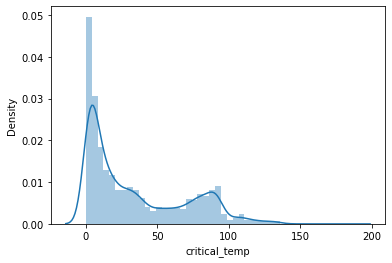

In [10]:
sns.distplot(df['critical_temp']);

#### Distribution of Log of Critical Temperature

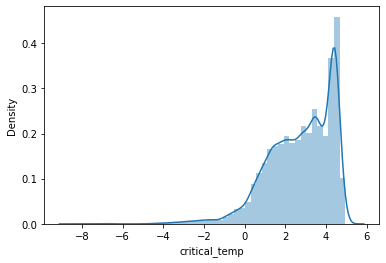

In [11]:
sns.distplot(np.log(df['critical_temp']));

#### Distribution of Final Model Residuals
The distribution of the model residuals is approximately normal and does not violate any key model assumptions.

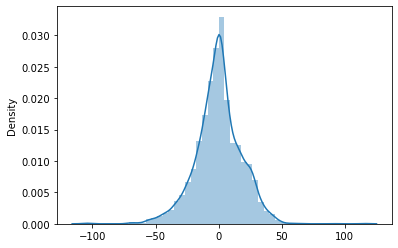

In [12]:
Image(filename='resid_hist.png') 

### Feature Correlations with Critical Temp
The team explored correlations of individual material characteristics with Critical Temp.  The feature "wtd_std_ThermalConductivity" had the highest correlation with r = 0.72.  

In [13]:
print(characteristics[characteristics.columns[1:]].corr()['critical_temp'][:-1].sort_values())

wtd_mean_Valence              -0.632401
wtd_gmean_Valence             -0.615653
mean_Valence                  -0.600085
gmean_Valence                 -0.573068
gmean_Density                 -0.541684
                                 ...   
wtd_entropy_atomic_mass        0.626930
std_ThermalConductivity        0.653632
range_atomic_radius            0.653759
range_ThermalConductivity      0.687654
wtd_std_ThermalConductivity    0.721271
Name: critical_temp, Length: 80, dtype: float64


### Feature Collinearity - Material Characteristics
The team examined the collinearity between material characterstics and decided to manually remove the following three after LASSO feature selection.

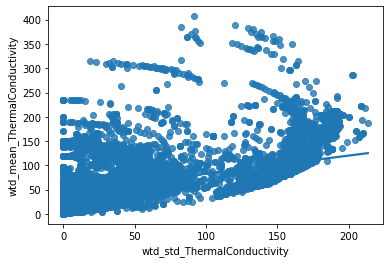

In [14]:
sns.regplot(y='wtd_mean_ThermalConductivity', x='wtd_std_ThermalConductivity', data=characteristics);

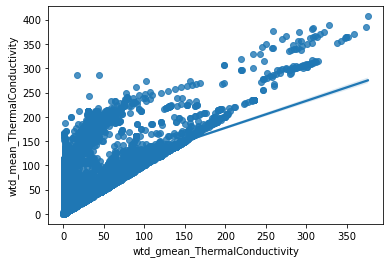

In [15]:
sns.regplot(y='wtd_mean_ThermalConductivity', x='wtd_gmean_ThermalConductivity', data=characteristics);

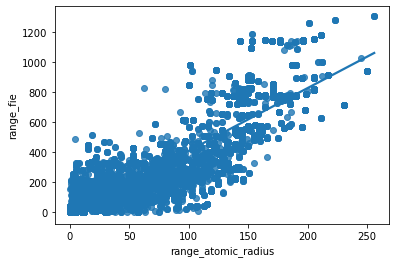

In [16]:
sns.regplot(x='range_atomic_radius', y='range_fie', data=characteristics);

### Feature Outliers - Material Characteristics
Material characteristics were also assessed for any outliers.  About 9% of the data were >4 stdev from the mean.  However, this would be an excessive amount of data to eliminate from the dataset, so they were not eliminated.   

In [17]:
outliers = pd.DataFrame()
for col in characteristics.columns:
    col_zscore = col + "_zscore"
    outliers[col_zscore] = (characteristics[col] - characteristics[col].mean())/characteristics[col].std(ddof=0)

z_scores = stats.zscore(characteristics)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 4).all(axis=1)
new_df = characteristics[filtered_entries]

1 - new_df.shape[0]/outliers.shape[0]

0.08752292715044918

### Elemental Outliers
Outliers of elemental variables were identified based on visual inspection of boxplots. Outliers were at least twice as far from the next highest point.

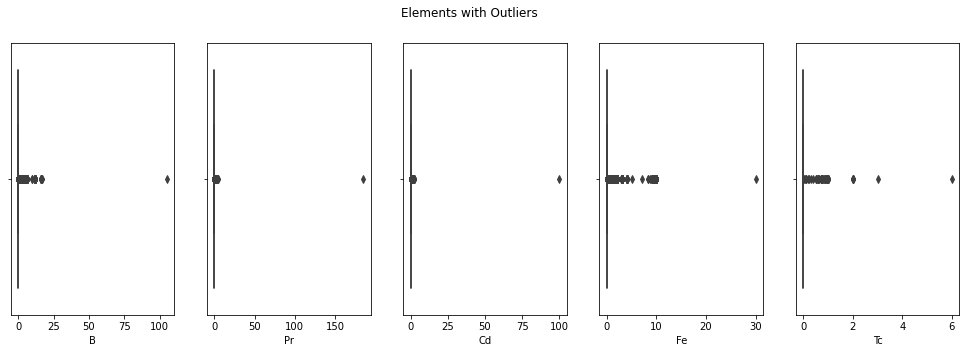

In [18]:
fig, axes = plt.subplots(1, 5, figsize=(17, 5))
fig.suptitle('Elements with Outliers')
outlier_elem = ['B', 'Pr', 'Cd', 'Fe', 'Tc']
for i,j in zip(outlier_elem, range(5)):
    sns.boxplot(ax = axes[j], x = materials[i]); 

In [19]:
df = df[ df['B'] < df['B'].max() ]
df = df[ df['Pr'] < df['Pr'].max() ]
df = df[ df['Cd'] < df['Cd'].max() ]
df = df[ df['Fe'] < df['Fe'].max() ]
df = df[ df['Tc'] < df['Tc'].max() ]
df = df[ df.index != 5918] # outlier in log transform models
print(df.shape)

(21257, 159)


### Feature Skewness
Several material characteristic features were highly right-skewed with skewness > 1.0.  This is likely because the features are non-negative.  The team will proceed with caution and check the model residuals as needed.       

In [20]:
df_skew = characteristics.skew()
for col in characteristics.columns:
    if abs(df_skew.loc[col]) > 1:
        print(df_skew.loc[col],col)

1.5039066527525748 wtd_mean_atomic_mass
1.474815716460679 gmean_atomic_mass
1.6982799470264727 wtd_gmean_atomic_mass
2.463807863929849 wtd_range_atomic_mass
1.0097642804575013 mean_fie
1.1919286264562292 gmean_fie
1.6431624609037285 wtd_range_atomic_radius
2.103343841114579 mean_Density
2.1377633652220895 wtd_mean_Density
1.6591282559918126 gmean_Density
1.6509298548729714 wtd_gmean_Density
3.3227255568242304 wtd_range_Density
1.098437437881419 mean_ElectronAffinity
1.3497357705423985 gmean_ElectronAffinity
2.52278188047039 mean_FusionHeat
2.7638258028710343 wtd_mean_FusionHeat
2.665477197882816 gmean_FusionHeat
2.4875423104652383 wtd_gmean_FusionHeat
2.7485818063583047 range_FusionHeat
4.233613879127433 wtd_range_FusionHeat
2.822554806107452 std_FusionHeat
2.8501338006914527 wtd_std_FusionHeat
1.379703282816514 wtd_mean_ThermalConductivity
2.3399514687914174 gmean_ThermalConductivity
2.5883047943944177 wtd_gmean_ThermalConductivity
1.4159181865406287 wtd_range_ThermalConductivity
1.00

### Assumptions

#### Target Variable Interpretation

According to our research, the Kelvin temperature scale is used for temperature instead of Fahrenheit or Celsius in semiconductor research and manufacturing.  Scientists and engineers use the Kelvin scale because it is a temperature scale where the value zero reflects the complete absence of thermal energy.  The Kelvin scale does not have negative temperatures since 0 degrees kelvin is the lowest temperature.  Because negative temperatures do not exist on the Kelvin scale, in our modeling, we replaced negative predicted values with 0.

# Model Preparations <a id='model-preparations'>

## Sampling & Scaling Data

In [21]:
# Define y and X
y = np.array( df['critical_temp'] )
df = df.drop(['critical_temp'], axis =1)
X = df

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1234321) 

# Center and Scale X
scl = StandardScaler()
scl.fit(X_train)
X_train_scaled = scl.transform(X_train) # apply to training
X_test_scaled = scl.transform(X_test) # apply to the test set (without snooping)

# Keep the feature names
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X.columns, index = X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X.columns, index = X_test.index)

## Proposed Method

After combining the two data files, the data set contained 158 features to start. This dataset was very complex to interpret and drive any kind of correlation, which may result in over-fitting the model. After initial exploration of the dataset, the team built a linear model with all 158 features as a baseline. Followed by the linear model using a LASSO algorithm to select the most pertinent variables, and then Ridge regression to fit the model using the smaller set of variables chosen to reduce the chances of overfitting without further reducing the number of variables. 

The primary objective was to reduce the number of explanatory variables, to build a meaningful model and ensure the accuracy and explain ability of a dependable variable by the independent variable is not compromised.  The LASSO algorithm is appropriate because it produces simpler and more interpretable models with a reduced set of the predictors. 

## Evaluation Metrics
 The prime criteria to evaluate the model was to minimize the error (mean square error) and increase the explanation of the relationship between independent and dependent variables (R<sup>2</sup>). The team also made a few manual adjustments to optimize (trade-off) the model's accuracy and enhance the model interpretation. The team investigated the correlations, checked the multicollinearity, and kept the most relevant features. 

### Baseline Model - Linear Model with All Features
The team chose a "naive" full linear model with all 158 features as the baseline starting point for model comparison because it requires little to no pre-processing and can be run quickly and easily.  

In [22]:
LR = LinearRegression()

# Cross validation on training set

LR_CV = cross_validate(LR, X_train_scaled, y_train, cv = 5, scoring=['neg_root_mean_squared_error','r2'])
LR_CV_RMSE = [round(-i,2) for i in LR_CV['test_neg_root_mean_squared_error']]
print( "LinReg CV 5 Folds RMSE =", LR_CV_RMSE )
print( "LinReg CV Avg. RMSE =", round(np.mean(LR_CV_RMSE),2) )
LR_CV_Rsq = [round(i,3) for i in LR_CV['test_r2']]
print( "\nLinReg CV 5 Folds R-sq =", LR_CV_Rsq )
print( "LinReg CV Avg. R-sq =", round(np.mean(LR_CV_Rsq),3) )

# Training & Test Set

LR.fit(X_train_scaled, y_train)
y_hat_train = LR.predict(X_train_scaled)
RMSE = round(mse(y_train, y_hat_train, squared=False), 2)
print( "\nLinReg Training RMSE =", round(RMSE,2) )
Rsq = r2_score(y_train, y_hat_train)
print( "LinReg Training R-Sq =", round(Rsq,3) )

y_hat_test = LR.predict(X_test_scaled)
RMSE = round(mse(y_test, y_hat_test, squared=False), 2)
print( "\nLinReg Test RMSE =", round(RMSE,2) )
Rsq = r2_score(y_test, y_hat_test)
print( "LinReg Test R-Sq =", round(Rsq,3) )

LinReg CV 5 Folds RMSE = [16.75, 16.84, 17.16, 16.99, 16.51]
LinReg CV Avg. RMSE = 16.85

LinReg CV 5 Folds R-sq = [0.763, 0.758, 0.744, 0.759, 0.773]
LinReg CV Avg. R-sq = 0.759

LinReg Training RMSE = 16.58
LinReg Training R-Sq = 0.767

LinReg Test RMSE = 16.26
LinReg Test R-Sq = 0.771


## Feature Selection with LASSO

In order reduce the number of parameters we wanted to find the point at which rmse and R<sup>2</sup> begins to flatten after  each additional paramater is added. This is the point of dimishing returns, also known as the "knee point". Depending on the target metric, the optimal penalty (alpha) is estimated. Targeting R<sup>2</sup> the estimated point of dimishing returns is alpha=0.9. Targeting RMSE the estimated point of dimishing returns is alpha=0.85.  The team chose the larger alpha=0.9 to have fewer features in the model.    

### Identifying Knee Points 

In [23]:
Lasso_df = []
L1 = Lasso()

for i in np.linspace(0, 5, 101):
    L1.alpha = i
  
    # Cross validation on training set
    L1_CV = cross_validate(L1, X_train_scaled, y_train, cv = 5, scoring=['neg_root_mean_squared_error','r2'])
    L1_CV_RMSE = round(np.mean(-L1_CV['test_neg_root_mean_squared_error']), 3)
    L1_CV_Rsq = round(np.mean(L1_CV['test_r2']), 4)
    
    L1.fit(X_train_scaled, y_train)
    num_terms = len(L1.coef_[L1.coef_!=0])
    
    Lasso_df.append([ L1.alpha, num_terms, L1_CV_RMSE, L1_CV_Rsq ])
    
Lasso_df = pd.DataFrame(Lasso_df, columns = ['Lasso alpha', '# Terms', 'CV RMSE', 'CV R-squared'])

#### RMSE Knee Point and # Features

In [24]:
kn1 = KneeLocator(Lasso_df['CV RMSE'], Lasso_df['# Terms'], curve='convex', direction='decreasing', S=2)
# S=2 chooses the second knee that is visually more prominent

print('CV RMSE', kn1.knee)
kn1_terms = Lasso_df[Lasso_df['CV RMSE']==kn1.knee]['# Terms'].item()
print('# Features', kn1_terms)

CV RMSE 19.168
# Features 21


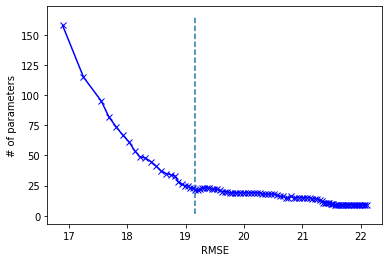

In [25]:
plt.xlabel('RMSE')
plt.ylabel('# of parameters')
plt.plot(Lasso_df['CV RMSE'], Lasso_df['# Terms'], 'bx-')
plt.vlines(kn1.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')

#### R<sup>2</sup> Knee Point and # Features

In [26]:
kn2 = KneeLocator(Lasso_df['CV R-squared'],  Lasso_df['# Terms'], curve='convex', direction='increasing')
print('CV R-squared', kn2.knee)
kn2_terms = Lasso_df[Lasso_df['CV R-squared']==kn2.knee]['# Terms'].item()
print('# Features', kn2_terms)

CV R-squared 0.6942
# Features 25


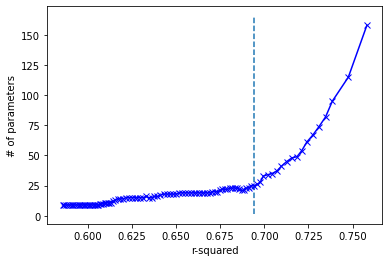

In [27]:
import matplotlib.pyplot as plt
plt.xlabel('r-squared')
plt.ylabel('# of parameters')
plt.plot(Lasso_df['CV R-squared'], Lasso_df['# Terms'], 'bx-')
plt.vlines(kn2.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')

#### RMSE Knee Point and Alpha

In [28]:
kn3 = KneeLocator(Lasso_df['Lasso alpha'],Lasso_df['CV RMSE'], curve='concave', direction='increasing')
print('Lasso alpha', kn3.knee)
kn3_rmse = Lasso_df[Lasso_df['Lasso alpha']==kn3.knee]['CV RMSE'].item()
print('RMSE', kn3_rmse)

Lasso alpha 0.9
RMSE 18.984


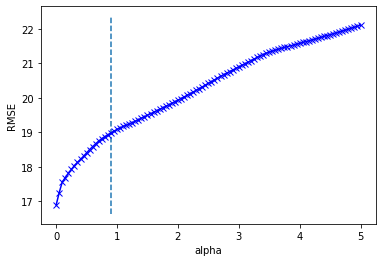

In [29]:
import matplotlib.pyplot as plt
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.plot(Lasso_df['Lasso alpha'],Lasso_df['CV RMSE'], 'bx-')
plt.vlines(kn3.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')

#### R-squared Knee point and Alpha


In [30]:
kn4 = KneeLocator(Lasso_df['Lasso alpha'],Lasso_df['CV R-squared'], curve='convex', direction='decreasing')
print('Lasso alpha', round(kn4.knee,3))
kn3_rsq = Lasso_df[Lasso_df['Lasso alpha']==kn3.knee]['CV R-squared'].item()
print('CV R-squared', kn3_rsq)

Lasso alpha 0.85
CV R-squared 0.6942


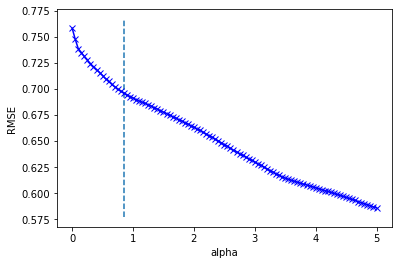

In [31]:
import matplotlib.pyplot as plt
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.plot(Lasso_df['Lasso alpha'],Lasso_df['CV R-squared'], 'bx-')
plt.vlines(kn4.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')

### Feature Selection with Tuned Alpha

In [32]:
L1 = Lasso(alpha = .9)
L1.fit(X_train_scaled, y_train)

y_hat_train = L1.predict(X_train_scaled)
RMSE = round(mse(y_train, y_hat_train, squared=False), 2)
print( "Lasso Training RMSE =", round(RMSE,2) )
Rsq = r2_score(y_train, y_hat_train)
print( "Lasso Training R-Sq =", round(Rsq,3) )

y_hat_test = L1.predict(X_test_scaled)
RMSE = round(mse(y_test, y_hat_test, squared=False), 2)
print( "\nLasso Test RMSE =", round(RMSE,2) )
Rsq = r2_score(y_test, y_hat_test)
print( "Lasso Test R-Sq =", round(Rsq,3) )

model_coef = pd.DataFrame(zip(X.columns, L1.coef_), columns=['Factor','Coef'])
model_factors = model_coef[model_coef['Coef']!=0]

Lasso Training RMSE = 18.87
Lasso Training R-Sq = 0.698

Lasso Test RMSE = 18.44
Lasso Test R-Sq = 0.706


In [33]:
print("\nKept Factors(", model_factors.shape[0], "of", X.shape[1],"):")
model_coef[model_coef['Coef']!=0].sort_values(by='Coef')


Kept Factors( 25 of 158 ):


,Factor,Coef
157,wtd_std_Valence,-3.551243
121,wtd_gmean_ElectronAffinity,-3.256133
11,Si,-2.542338
110,gmean_Density,-1.791377
53,Pr,-1.664248
141,wtd_gmean_ThermalConductivity,-1.336341
29,As,-0.801547
137,wtd_std_FusionHeat,-0.710089
52,Ce,-0.656177
54,Nd,-0.464878


#### Replace Negative Predictions
Cannot have negative degrees Kelvin as mentioned previously in the Assumptions section.  Set any negative predictions to 0 and reassess performance.  Training and test metrics are very similar, indicating the model performs consistently before vs. after replacing negative predictions. <b>Moving forward, all negative temperature predictions will be replaced with 0.</b>

In [34]:
y_hat_train[y_hat_train<0]=0
RMSE = round(mse(y_train, y_hat_train, squared=False), 2)
print( "\nLinReg Training RMSE =", round(RMSE,2) )
Rsq = r2_score(y_train, y_hat_train)
print( "LinReg Training R-Sq =", round(Rsq,3) )

y_hat_test[y_hat_test<0]=0
RMSE = round(mse(y_test, y_hat_test, squared=False), 2)
print( "\nLinReg Test RMSE =", round(RMSE,2) )
Rsq = r2_score(y_test, y_hat_test)
print( "LinReg Test R-Sq =", round(Rsq,3) )


LinReg Training RMSE = 18.77
LinReg Training R-Sq = 0.702

LinReg Test RMSE = 18.36
LinReg Test R-Sq = 0.709


### Todo: Removing Remaining Collinearity
Refer to section 'Feature Collinearity - Material Characteristics'

In [35]:
model_factors= model_factors[model_factors['Factor'] != 'wtd_gmean_ThermalConductivity']
model_factors= model_factors[model_factors['Factor'] != 'wtd_std_ThermalConductivity']
model_factors= model_factors[model_factors['Factor'] != 'range_fie']

# Model Building & Evaluations <a id='#model-building'>

## Sampling Methodology

Per the code above we used a 70/30 train test sample split with 5 fold internal cross validation for training, to tune alpha for feature selection in our final model


## Ridge Model Built from Lasso Model Selection

Describe model
specifying the regularization type chosen and including the parameters utilized by the model


In [36]:
L2 = Ridge(alpha = .9)
model_terms = list(model_factors['Factor'])
L2.fit(X_train_scaled[model_terms], y_train)

y_hat_train = L2.predict(X_train_scaled[model_terms])
y_hat_train[y_hat_train<0]=0 # Replace
RMSE = round(mse(y_train, y_hat_train, squared=False), 2)
print( "Ridge Training RMSE =", round(RMSE,2) )
Rsq = r2_score(y_train, y_hat_train)
print( "Ridge Training R-Sq =", round(Rsq,3) )

y_hat_test = L2.predict(X_test_scaled[model_terms])
y_hat_test[y_hat_test<0]=0
RMSE = round(mse(y_test, y_hat_test, squared=False), 2)
print( "\nRidge Test RMSE =", round(RMSE,2) )
Rsq = r2_score(y_test, y_hat_test)
print( "Ridge Test R-Sq =", round(Rsq,3) )

model_coef1 = pd.DataFrame(zip(X[model_terms].columns, L2.coef_), columns=['Factor','Coef'])
model_factors1 = model_coef1[model_coef1['Coef']!=0]

Ridge Training RMSE = 18.55
Ridge Training R-Sq = 0.709

Ridge Test RMSE = 18.09
Ridge Test R-Sq = 0.717


In [37]:
print("\nKept Factors(", model_factors1.shape[0], "of", X.shape[1],"):")
model_coef1[model_coef1['Coef']!=0].sort_values(by=['Coef'])


Kept Factors( 22 of 158 ):


,Factor,Coef
21,wtd_std_Valence,-5.503262
0,Si,-4.148167
17,gmean_Density,-3.782411
18,wtd_gmean_ElectronAffinity,-3.090151
19,wtd_std_FusionHeat,-3.012947
3,As,-2.541149
8,Pr,-2.285263
7,Ce,-1.265167
2,Ge,-1.206696
9,Nd,-1.143237


## Model's Performance Analysis

__72%__ of the variation can be explained by the features (R<sup>2</sup>). The model error (RMSE) was __18 degrees K__. The team observed a few outliers in the training set, however no outliers were identified in the test set. Team was not able to attribute these outliers to specific variables. 

At the beginning of the study the team built a baseline model with all __158 features__ using simple linear regression, this maximized performance, but minimized model interpretability and increased the complexity. Following are the outcomes of the baseline model: 

__LinReg Test RMSE = 16.26 <br>__
__LinReg Test R-Sq = 0.771 <br>__


After using LASSO feature selection and manual elimination of collinear features the final ridge model utilized only __22 features__ (9 material characteristics and 13 elements) which is and __86% reduction of features__, while only increasing the __RMSE by 1.8 degrees Kelvin__ and reducing the __R<sup>2</sup> by 6.5%__. Following are the outcomes for the final Ridge model:



__Ridge Test RMSE = 18.09 <br>__
__Ridge Test R-Sq = 0.717 <br>__


#### Actual vs. Predicted 

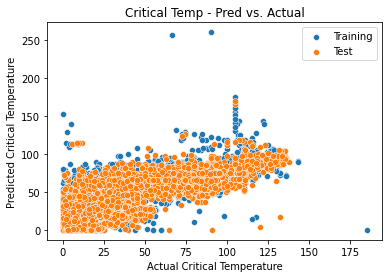

In [38]:
sns.scatterplot(x = y_train, y = y_hat_train)
sns.scatterplot(x = y_test, y = y_hat_test).set(title='Critical Temp - Pred vs. Actual')

plt.legend(['Training', 'Test'])
plt.xlabel('Actual Critical Temperature')
plt.ylabel('Predicted Critical Temperature')
plt.show()

# Model Interpretability & Explainability <a id='model-explanation'>

## Examining Feature Importance


Given that our inputs were scaled, we derived the importance of each variable based on the magnitude of the feature coefficients in the model. Features with positive coefficients drive the critical temperature upwards, while features with negative coefficients drive the critical temperature downwards.

Variables related to Atomic Mass, Thermal Conductivity and Atomic Radius have a high positive influence on critical temperature (show positive correlation) of superconductors to achieve superconductivity. Also, the presence of Barium (Ba), Calcium (Ca) and Bismuth (Bi) helps increase the critical temperature. All these variables have the highest scaled coefficients in our model. 

Variables related to Valence, Density, Electron Affinity, and Fusion Heat have a high negative influence on critical temperatures. Additionally the presence of Silicon (Si), Arsenic (As), Praseodymium (Pr) decrease the critical temperature.



In [39]:
model_coef1.sort_values(by=['Coef'])

,Factor,Coef
21,wtd_std_Valence,-5.503262
0,Si,-4.148167
17,gmean_Density,-3.782411
18,wtd_gmean_ElectronAffinity,-3.090151
19,wtd_std_FusionHeat,-3.012947
3,As,-2.541149
8,Pr,-2.285263
7,Ce,-1.265167
2,Ge,-1.206696
9,Nd,-1.143237


# Conclusion <a id='conclusion'>
    


### Final Model Proposal

We're proposing a linear regression model (with LASSO and Ridge algorithms) to reduce the number of features and prevent overfitting, that predicts the critical temperatures using 9 material characteristics and 13 elements out of the 158 total features (81 materical characteristics and 77 elements) provided. Our model achieved and R<sup>2</sup> of 0.72 and an RMSE of 18 degrees K. One of our primary goals was to achieve high model interpretability and reduce the model complexity while at the same time minimizing impact on model performance.  

### Future Considerations and Model Enhancements

Attempt to build two separate models for low and high temperature superconductors. We noticed that our observations might come from two separate populations since distribution appears to be bimodal. This in turn could reduce the RMSE of each model.

### Alternative Modeling Approaches

The team also recommends exploring nonlinear modeling (e.g. boosted trees, random forest) to better handle skewness and outliers in the data. 